## Four Corner Shell Bending Example

In [ ]:
import numpy as np

import dismech

geom = dismech.GeomParams(rod_r0=0,
                          shell_h=1e-3)

material = dismech.Material(density=1200,
                            youngs_rod=0,
                            youngs_shell=2e11,  # stainless steel
                            poisson_rod=0,
                            poisson_shell=0.5)

static_3d_sim = dismech.SimParams(static_sim=True,
                                  two_d_sim=False,
                                  use_mid_edge=False,
                                  use_line_search=False,
                                  show_floor=False,
                                  log_data=True,
                                  log_step=1,
                                  dt=1e-2,
                                  max_iter=25,
                                  total_time=1e-2,
                                  plot_step=10,
                                  tol=1e-4,
                                  ftol=1e-4,
                                  dtol=1e-2)

env = dismech.Environment()
env.add_force('gravity', g=np.array([0.0, 0.0, -9.81]))

geo = dismech.Geometry.from_txt('four_corner.txt')

robot = dismech.SoftRobot(geom, material, geo, static_3d_sim, env)

### Energy

In [ ]:
import dismech.elastics

# set strain_bar
stretch_energy = dismech.elastics.StretchEnergy(robot.stretch_springs, robot.state)
# FIXME: Mid-edge breaks for this!!
if robot.sim_params.use_mid_edge:
    shell_energy = dismech.elastics.TriangleEnergy(robot.triangle_springs, robot.state)
else:
    shell_energy = dismech.elastics.HingeEnergy(robot.hinge_springs, robot.state)

### Static Simulation

In [6]:
robot = robot.fix_nodes([0,1,2])
stepper = dismech.ImplicitEulerTimeStepper(robot)
robots = stepper.simulate()
qs = np.stack([robot.state.q for robot in robots])

# Static Sim = 1 output
robot_eq = robots[-1]
q_eq = robots[-1].state.q

  0%|          | 0/1 [00:00<?, ?it/s]

### Visualization

In [7]:
t = np.arange(robot.sim_params.total_time, step=robot.sim_params.dt)  # (100)
options = dismech.AnimationOptions(z_lim=[-1.0, 1.0], x_lim=[0, 1.0], title='Four Corners')
fig = dismech.get_interactive_animation_plotly(robot, t, np.array([q_eq]), options)
fig.show()

### Energy

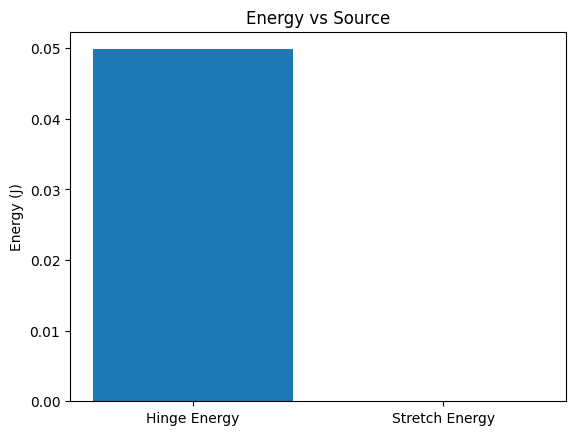

Stretch Energy: 5.96964998571525e-11


In [8]:
import matplotlib.pyplot as plt

plt.bar(["Hinge Energy", "Stretch Energy"], [shell_energy.get_energy_linear_elastic(robot_eq.state), stretch_energy.get_energy_linear_elastic(robot_eq.state)])
plt.title("Energy vs Source")
plt.ylabel("Energy (J)")
plt.show()

print("Stretch Energy: {}".format(stretch_energy.get_energy_linear_elastic(robot_eq.state)))

## Dihedral Angle Calculation

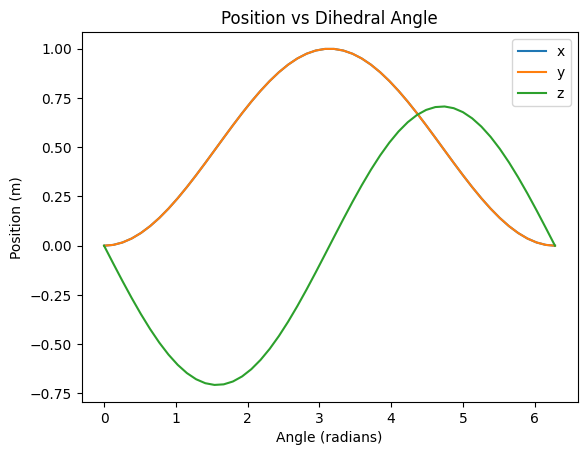

In [9]:
# CHATGPT
def get_node4_folded_position(theta):
    A = np.array([0, 1, 0])
    B = np.array([1, 0, 0])

    K = B - A
    K = K / np.linalg.norm(K)
    ref_vector = np.array([1, 1, 0]) - A
    M = np.cross(K, ref_vector)
    M = M / np.linalg.norm(M)
    N = np.cross(M, K)
    radius = np.linalg.norm(ref_vector - np.dot(ref_vector, K) * K)
    rotated_point = (
        A
        + np.dot(ref_vector, K) * K
        + radius * (np.cos(theta - np.pi) * N + np.sin(theta - np.pi) * M)
    )
    
    return np.array(rotated_point)

# Get displaced positions
thetas = np.linspace(0 + 1e-4, 2 * np.pi - 1e-4)
positions = [get_node4_folded_position(theta) for theta in thetas] 

plt.plot(thetas, positions, label=['x', 'y', 'z'])
plt.title("Position vs Dihedral Angle")
plt.xlabel('Angle (radians)')
plt.ylabel('Position (m)')
plt.legend()
plt.show()

In [ ]:
# Create a robot with all fixed nodes (w/o gravity)
base_robot = dismech.SoftRobot(geom, material, geo, static_3d_sim, dismech.Environment())
base_robot = base_robot.fix_nodes([0,1,2,3])

robots = []
he = []
se = []

# For each position, displace the node and evaluate the hinge and stretching energy
for pos in positions:
    disp_robot = base_robot.move_nodes([3], pos - np.array([1,1,0]))
    robots.append(disp_robot)
    he.append(shell_energy.get_energy_linear_elastic(disp_robot.state))
    se.append(stretch_energy.get_energy_linear_elastic(disp_robot.state))

qs = np.stack([robot.state.q for robot in robots])

### Visualization

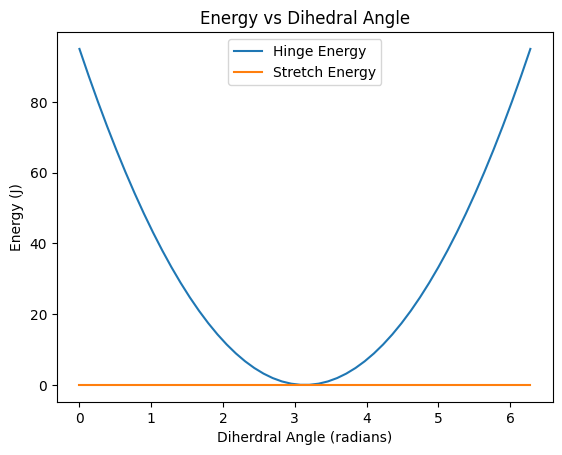

In [11]:
plt.plot(thetas, he, label='Hinge Energy')
plt.plot(thetas, se, label='Stretch Energy')
plt.title('Energy vs Dihedral Angle')
plt.ylabel('Energy (J)')
plt.xlabel('Diherdral Angle (radians)')
plt.legend()
plt.show()

In [12]:
options = dismech.AnimationOptions(z_lim=[-1.0, 1.0], x_lim=[0, 1.0], title='Four Corners')
fig = dismech.get_interactive_animation_plotly(base_robot, thetas, qs, options)
fig.show()